# Final Project

## Scott Scheraga  7/24/2020





In [1]:
#Code is largely built off of https://keras.io/examples/rl/ddpg_pendulum/
#HER code is inspired by pybullet code at https://github.com/buntyke/her/blob/master/ddpg_her.py

#from gym.envs.registration import registry, make, spec, register
#python -m pybullet_envs.examples.enjoy_TF_HalfCheetahBulletEnv_v0_2017may


import gym
import pybullet_envs
import tensorflow as tf
from tensorflow.keras import layers
import numpy as np
import matplotlib.pyplot as plt
from gym import wrappers
from IPython import display

from datetime import datetime

%matplotlib inline
import math 

import os
import gym
from gym import utils
from gym.envs import mujoco
import mujoco_py
import cv2
from gym.envs.robotics import fetch_env
import threading
threading.activeCount()


import multiprocessing

def worker():
    """worker function"""
    print ('Worker')
    return

if __name__ == '__main__':
    jobs = []
    for i in range(20):
        p = multiprocessing.Process(target=worker)
        jobs.append(p)
        p.start()
        
threading.activeCount()


Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker
Worker

5

WorkerWorkerWorker



Worker


In [2]:

#env = gym.make('Pendulum-v0')
#env = gym.make('CartPole-v1')
#env = gym.make('HalfCheetahBulletEnv-v0')


#env = gym.make('FetchPickAndPlace-v1')


env = gym.make('FetchPush-v1')
#env = gym.make('FetchReach-v1')

#env = gym.make('Reacher-v2')

#Env information at:
# https://medium.com/@Amritpal001/intro-to-robotics-in-openai-fetch-reach-env-automating-robotics-with-reinforcement-learning-part-2b7452f3a5e9

print("Obs space")
print(env.observation_space) #.shape
print(env.observation_space.sample())
print(" ")
print(" ")
print("Action space")
print(env.action_space) #.shape
print(env.action_space.sample())
num_states = env.observation_space['observation'].shape[0]
num_goals = env.observation_space['achieved_goal'].shape[0]
print("numgoals=",num_goals)

#num_states = env.observation_space.shape[0]
print(" ")
print(" ")
#num_states=25
print("Size of State Space ->  {}".format(num_states))
num_actions = env.action_space.shape[0]
print("Size of Action Space ->  {}".format(num_actions))

upper_bound = env.action_space.high[0]
lower_bound = env.action_space.low[0]

print("Max Value of Action ->  {}".format(upper_bound))
print("Min Value of Action ->  {}".format(lower_bound))
print(" ")
print(" ")
print(" ")
#print("initial_state")
#print(env.initial_state)


Obs space
Dict(achieved_goal:Box(3,), desired_goal:Box(3,), observation:Box(25,))
OrderedDict([('achieved_goal', array([ 0.80702317, -0.41659766,  1.3797944 ], dtype=float32)), ('desired_goal', array([ 0.96165097, -0.1151522 , -0.32118118], dtype=float32)), ('observation', array([ 0.47664648,  0.05384037, -1.0257145 ,  1.2507931 ,  0.09884124,
       -0.8271967 ,  1.5255164 ,  0.20657344, -0.23348081,  1.3605086 ,
       -1.6013582 ,  0.1732245 ,  1.7306662 , -0.13927211,  0.05484232,
       -0.69705874,  0.9848244 , -0.21922173, -0.5423336 ,  0.6368394 ,
       -1.5924684 ,  0.09700383, -0.21450408,  0.5101458 , -1.7884041 ],
      dtype=float32))])
 
 
Action space
Box(4,)
[-0.7104479   0.69475764  0.15510811 -0.8451068 ]
numgoals= 3
 
 
Size of State Space ->  25
Size of Action Space ->  4
Max Value of Action ->  1.0
Min Value of Action ->  -1.0
 
 
 


In [3]:
#Fetch reach definition
#https://github.com/openai/gym/blob/master/gym/envs/robotics/fetch/reach.py
"""
from gym import utils
from gym.envs.robotics import fetch_env


# Ensure we get the path separator correct on windows
MODEL_XML_PATH = os.path.join('fetch', 'reach.xml')


class FetchReachEnv(fetch_env.FetchEnv, utils.EzPickle):
    def __init__(self, reward_type='sparse'):
        initial_qpos = {
            'robot0:slide0': 0.4049,
            'robot0:slide1': 0.48,
            'robot0:slide2': 0.0,
        }
        fetch_env.FetchEnv.__init__(
            self, MODEL_XML_PATH, has_object=False, block_gripper=True, n_substeps=20,
            gripper_extra_height=0.2, target_in_the_air=True, target_offset=0.0,
            obj_range=0.15, target_range=0.15, distance_threshold=0.05,
            initial_qpos=initial_qpos, reward_type=reward_type)
        utils.EzPickle.__init__(self)
        
"""

"\nfrom gym import utils\nfrom gym.envs.robotics import fetch_env\n\n\n# Ensure we get the path separator correct on windows\nMODEL_XML_PATH = os.path.join('fetch', 'reach.xml')\n\n\nclass FetchReachEnv(fetch_env.FetchEnv, utils.EzPickle):\n    def __init__(self, reward_type='sparse'):\n        initial_qpos = {\n            'robot0:slide0': 0.4049,\n            'robot0:slide1': 0.48,\n            'robot0:slide2': 0.0,\n        }\n        fetch_env.FetchEnv.__init__(\n            self, MODEL_XML_PATH, has_object=False, block_gripper=True, n_substeps=20,\n            gripper_extra_height=0.2, target_in_the_air=True, target_offset=0.0,\n            obj_range=0.15, target_range=0.15, distance_threshold=0.05,\n            initial_qpos=initial_qpos, reward_type=reward_type)\n        utils.EzPickle.__init__(self)\n        \n"

In [4]:
class OUActionNoise:
    def __init__(self, mean, std_deviation, theta=0.15, dt=1e-2, x_initial=None):
        self.theta = theta
        self.mean = mean
        self.std_dev = std_deviation
        self.dt = dt
        self.x_initial = x_initial
        self.reset()

    def __call__(self):
        # Formula taken from https://www.wikipedia.org/wiki/Ornstein-Uhlenbeck_process.
        x = (
            self.x_prev
            + self.theta * (self.mean - self.x_prev) * self.dt
            + self.std_dev * np.sqrt(self.dt) * np.random.normal(size=self.mean.shape)
        )
        # Store x into x_prev
        # Makes next noise dependent on current one
        self.x_prev = x
        return x

    def reset(self):
        if self.x_initial is not None:
            self.x_prev = self.x_initial
        else:
            self.x_prev = np.zeros_like(self.mean)


In [5]:
class Buffer:
    def __init__(self, buffer_capacity=100000, batch_size=256):
    
        # Number of "experiences" to store at max
        self.buffer_capacity = buffer_capacity
        # Num of tuples to train on.
        self.batch_size = batch_size

        # Its tells us num of times record() was called.
        self.buffer_counter = 0

        # Instead of list of tuples as the exp.replay concept go
        # We use different np.arrays for each tuple element
        self.state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.action_buffer = np.zeros((self.buffer_capacity, num_actions))
        self.reward_buffer = np.zeros((self.buffer_capacity, 1))
        self.next_state_buffer = np.zeros((self.buffer_capacity, num_states))
        self.achieved_goal_buffer = np.zeros((self.buffer_capacity, num_goals))
        self.goal_buffer = np.zeros((self.buffer_capacity, num_goals)) 

    # Takes (s,a,r,s') obervation tuple as input
    def record(self, obs_tuple):
        # Set index to zero if buffer_capacity is exceeded,
        # replacing old records
        index = self.buffer_counter % self.buffer_capacity

        self.state_buffer[index] = obs_tuple[0]
        self.action_buffer[index] = obs_tuple[1]
        self.reward_buffer[index] = obs_tuple[2]
        self.next_state_buffer[index] = obs_tuple[3]
        self.achieved_goal_buffer[index] = obs_tuple[4]
        self.goal_buffer[index] = obs_tuple[5]
        
        
        if self.buffer_counter<self.buffer_capacity:
            self.buffer_counter += 1
            

    # We compute the loss and update parameters
    def learn(self):
        # Get sampling range
        record_range = min(self.buffer_counter, self.buffer_capacity)
        # Randomly sample indices
        batch_indices = np.random.choice(record_range, self.batch_size)

        # Convert to tensors
        state_batch = tf.convert_to_tensor(self.state_buffer[batch_indices])
        action_batch = tf.convert_to_tensor(self.action_buffer[batch_indices])
        reward_batch = tf.convert_to_tensor(self.reward_buffer[batch_indices])
        reward_batch = tf.cast(reward_batch, dtype=tf.float32)
        next_state_batch = tf.convert_to_tensor(self.next_state_buffer[batch_indices])
        achieved_goal_batch = tf.convert_to_tensor(self.achieved_goal_buffer[batch_indices])
        goal_batch = tf.convert_to_tensor(self.goal_buffer[batch_indices])

        # Training and updating Actor & Critic networks.
        # See Pseudo Code.
        with tf.GradientTape() as tape:
            target_actions = target_actor(next_state_batch)
            y = reward_batch + gamma * target_critic([next_state_batch, target_actions])
            critic_value = critic_model([state_batch, action_batch])
            critic_loss = tf.math.reduce_mean(tf.math.square(y - critic_value))

        critic_grad = tape.gradient(critic_loss, critic_model.trainable_variables)
        critic_optimizer.apply_gradients(
            zip(critic_grad, critic_model.trainable_variables)
        )

        with tf.GradientTape() as tape:
            actions = actor_model(state_batch)
            critic_value = critic_model([state_batch, actions])
            # Used `-value` as we want to maximize the value given
            # by the critic for our actions
            actor_loss = -tf.math.reduce_mean(critic_value)

        actor_grad = tape.gradient(actor_loss, actor_model.trainable_variables)
        actor_optimizer.apply_gradients(
            zip(actor_grad, actor_model.trainable_variables)
        )


# This update target parameters slowly
# Based on rate `tau`, which is much less than one.
def update_target(tau):
    new_weights = []
    target_variables = target_critic.weights
    for i, variable in enumerate(critic_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_critic.set_weights(new_weights)

    new_weights = []
    target_variables = target_actor.weights
    for i, variable in enumerate(actor_model.weights):
        new_weights.append(variable * tau + target_variables[i] * (1 - tau))

    target_actor.set_weights(new_weights)


In [6]:
layersize=400

def get_actor():  #makes actor network
    # Initialize weights between -3e-3 and 3-e3
    last_init = tf.random_uniform_initializer(minval=-0.003, maxval=0.003)

    inputs = layers.Input(shape=(num_states,))
    out = layers.Dense(layersize, activation="relu")(inputs)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(layersize, activation="relu")(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(num_actions, activation="tanh", kernel_initializer=last_init)(out)
    # Our upper bound is 2.0 for Pendulum.
    outputs = outputs * upper_bound
    model = tf.keras.Model(inputs, outputs)
    return model
 
def get_critic():
    # State as input
    state_input = layers.Input(shape=(num_states))
    #state_out = layers.Dense(16, activation="relu")(state_input)#Changed from 16 to 512 in V5
    #state_out = layers.BatchNormalization()(state_out)
    #state_out = layers.Dense(32, activation="relu")(state_out)#Changed from 32 to 512 in V5
    #state_out = layers.BatchNormalization()(state_out) 

    # Action as input
    action_input = layers.Input(shape=(num_actions))
    #action_out = layers.Dense(32, activation="relu")(action_input)  #Changed from 32 to 512 in V5
    #action_out = layers.BatchNormalization()(action_out)#Changed from 32 to 512 in V5

 
    # Both are passed through seperate layer before concatenating
    #concat = layers.Concatenate()([state_out, action_out])
    concat = layers.Concatenate()([state_input, action_input])

    out = layers.Dense(layersize, activation="relu")(concat)
    out = layers.BatchNormalization()(out)
    out = layers.Dense(layersize, activation="relu")(out)
    out = layers.BatchNormalization()(out)
    outputs = layers.Dense(1)(out)

    # Outputs single value for give state-action
    model = tf.keras.Model([state_input, action_input], outputs)

    return model


In [7]:
def policy(state, noise_object):
    sampled_actions = tf.squeeze(actor_model(state))
    noise = noise_object()
    # Adding noise to action
    sampled_actions = sampled_actions.numpy() + noise

    # We make sure action is within bounds
    legal_action = np.clip(sampled_actions, lower_bound, upper_bound)

    return np.squeeze(legal_action)


In [8]:
std_dev = 0.2
ou_noise = OUActionNoise(mean=np.zeros(1), std_deviation=float(std_dev) * np.ones(1))

#actor_model = get_actor()
#critic_model = get_critic()

#target_actor = get_actor()
#target_critic = get_critic()
#print(actor_model.summary() )
#critic_model.summary() 

# Making the weights equal initially


# Learning rate for actor-critic models
critic_lr = 0.001  #originally .002
actor_lr = 0.001  #originally .001


#total_episodes = 100
# Discount factor for future rewards
gamma = 0.99
# Used to update target networks
tau = 0.01



 


In [9]:
# To store reward history of each episode

ep_reward_list = []
buffersize=100000
buffer = Buffer(buffersize, 128)  
actor_model = get_actor()
critic_model = get_critic()


target_actor = get_actor()
target_critic = get_critic()
target_actor.set_weights(actor_model.get_weights())
target_critic.set_weights(critic_model.get_weights())
critic_optimizer = tf.keras.optimizers.Adam(critic_lr)
actor_optimizer = tf.keras.optimizers.Adam(actor_lr)
"""
"""

HER_active=False
#K=4 #K is the ratio of HER buffer length to the regular buffer length

"""
actor_model.load_weights("chet_actor100v8.h5")
critic_model.load_weights("chet_critic100v8.h5")

target_actor.load_weights("chet_target_actor100v8.h5")
target_critic.load_weights("chet_target_critic100v8.h5")


with open('rewardlist400v5.txt', 'r') as filehandle:
    for line in filehandle:
        # remove linebreak which is the last character of the string
        currentPlace = line[:-1]

        # add item to the list
        ep_reward_list.append(currentPlace)

"""

#env.render()
#cymj.MjRenderContextOffscreen(self.sim, 0)
dateTimeObj = datetime.now()


print("Time is: ", dateTimeObj)


for ep in range(80000):
    
    if ep % 1000 ==0: 
        actor_model.save_weights("pushNOHER_actor.h5")
        critic_model.save_weights("pushNOHER_critic.h5")

        target_actor.save_weights("pushNOHER_target_actor.h5")
        target_critic.save_weights("pushNOHER_target_critic.h5")

        with open('rewardlistpushNOHER.txt', 'w') as filehandle:
            for listitem in ep_reward_list:
                filehandle.write('%s\n' % listitem)
                
    """"""           
    prev_state = env.reset()
    
    episodic_reward = 0
    #if HER_active==True:
    #epochbuffer = Buffer(50, 128)
    #epochHERbuffer = Buffer(50, 128)
    while True:
        
        #achievedcounter=0
        #env.render()

        tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state['observation']), 0)
        #tf_prev_state = tf.expand_dims(tf.convert_to_tensor(prev_state), 0)
        
        action = policy(tf_prev_state, ou_noise)
        # Recieve state and reward from environment.
        state, reward, done, info = env.step(action)

        #desired_goal
        #achieved_goal
        buffer.record((prev_state['observation'] ,action, 
                       reward, state['observation'],state['achieved_goal'],state['desired_goal']))
        
        episodic_reward += reward
        
        
        #epochbuffer.record((prev_state['observation'] ,action, 
        #               reward, state['observation'],state['achieved_goal'],state['desired_goal']))
        #buffer.record((prev_state, action, reward, state))
  
        
        # End this episode when `done` is True
        
        if done:
            break 
    """         
    if HER_active==True:
            #print("epochbuffer.buffer_counter=",epochbuffer.buffer_counter)
            tempreward=0
            
            
            
            
            for t in range(epochbuffer.buffer_counter):
                
                for k in range(4):
                        #For "future" strategy
                        strategyindex = np.random.randint(t,epochbuffer.buffer_counter)
                        
                        #For "final" strategy
                        #strategyindex = epochbuffer.buffer_counter-1
                        
                        #For "random" strategy
                        #strategyindex = np.random.randint(0,epochbuffer.buffer_counter)
                        

                        stateHER = epochbuffer.state_buffer[t]                 
                        actionHER = epochbuffer.action_buffer[t]
                        next_stateHER = epochbuffer.next_state_buffer[t]
                        achieved_goalHER = epochbuffer.achieved_goal_buffer[t]
                        
                        goalHER = epochbuffer.achieved_goal_buffer[strategyindex]
                        
                        rewardHER=env.compute_reward(achieved_goalHER, goalHER, info)
                        tempreward+=rewardHER
                        buffer.record((stateHER, actionHER, 
                                         rewardHER, next_stateHER, achieved_goalHER, goalHER))
                                    # add new experience to her
                        #epochHERbuffer.record((stateHER, actionHER, 
                                   #      rewardHER, next_stateHER, achieved_goalHER, goalHER))
    """                     
                        
            #print("HERreward=",tempreward)            
    #epochHERbuffer.learn()
            #del HERbuffer  
    #del epochbuffer  
        
    buffer.learn()    
    update_target(tau)    
    prev_state = state    
        
    ep_reward_list.append(episodic_reward)

    # Mean of last 40 episodes
    #avg_reward = np.mean(ep_reward_list[-40:])
    if ep % 100 ==0:
      #  print("Episode * {} *  HER Reward: {} *  Episodic Reward: {}".format(ep,tempreward, episodic_reward ))
        print("Episode * {} *  Episodic Reward: {}".format(ep, episodic_reward ))
            
    #print("buffersize= ",buffer.buffer_counter)
    #avg_reward_list.append(avg_reward)
    
dateTimeObj = datetime.now()
print("Time is: ", dateTimeObj)

# Plotting graph
# Episodes versus Avg. Rewards
plt.plot(ep_reward_list)
plt.xlabel("Episode")
plt.ylabel("Avg. Episodic Reward")
plt.show()




Time is:  2020-07-24 01:10:50.340263
Episode * 0 *  Episodic Reward: -50.0
Episode * 100 *  Episodic Reward: -50.0
Episode * 200 *  Episodic Reward: -50.0
Episode * 300 *  Episodic Reward: -50.0
Episode * 400 *  Episodic Reward: -50.0
Episode * 500 *  Episodic Reward: -50.0
Episode * 600 *  Episodic Reward: -50.0
Episode * 700 *  Episodic Reward: -50.0
Episode * 800 *  Episodic Reward: -50.0
Episode * 900 *  Episodic Reward: -50.0
Episode * 1000 *  Episodic Reward: -50.0
Episode * 1100 *  Episodic Reward: -50.0
Episode * 1200 *  Episodic Reward: -50.0
Episode * 1300 *  Episodic Reward: -50.0
Episode * 1400 *  Episodic Reward: -50.0
Episode * 1500 *  Episodic Reward: -50.0
Episode * 1600 *  Episodic Reward: -50.0
Episode * 1700 *  Episodic Reward: -50.0
Episode * 1800 *  Episodic Reward: -50.0
Episode * 1900 *  Episodic Reward: -50.0
Episode * 2000 *  Episodic Reward: -50.0
Episode * 2100 *  Episodic Reward: -50.0
Episode * 2200 *  Episodic Reward: -50.0
Episode * 2300 *  Episodic Rewar

Episode * 19800 *  Episodic Reward: -50.0
Episode * 19900 *  Episodic Reward: -50.0
Episode * 20000 *  Episodic Reward: -50.0
Episode * 20100 *  Episodic Reward: -50.0
Episode * 20200 *  Episodic Reward: -50.0
Episode * 20300 *  Episodic Reward: -50.0
Episode * 20400 *  Episodic Reward: -50.0
Episode * 20500 *  Episodic Reward: -50.0
Episode * 20600 *  Episodic Reward: -50.0
Episode * 20700 *  Episodic Reward: -50.0
Episode * 20800 *  Episodic Reward: -50.0
Episode * 20900 *  Episodic Reward: -50.0
Episode * 21000 *  Episodic Reward: 0.0
Episode * 21100 *  Episodic Reward: -50.0
Episode * 21200 *  Episodic Reward: -50.0
Episode * 21300 *  Episodic Reward: -50.0
Episode * 21400 *  Episodic Reward: -50.0
Episode * 21500 *  Episodic Reward: -50.0
Episode * 21600 *  Episodic Reward: -50.0
Episode * 21700 *  Episodic Reward: -50.0
Episode * 21800 *  Episodic Reward: -50.0
Episode * 21900 *  Episodic Reward: -50.0
Episode * 22000 *  Episodic Reward: -50.0
Episode * 22100 *  Episodic Reward: 

MujocoException: Got MuJoCo Warning: Nan, Inf or huge value in QACC at DOF 0. The simulation is unstable. Time = 0.4000.

In [11]:
actor_model.save_weights("pushNOHER_actor.h5")
critic_model.save_weights("pushNOHER_critic.h5")

target_actor.save_weights("pushNOHER_target_actor.h5")
target_critic.save_weights("pushNOHER_target_critic.h5")

with open('rewardlistpushNOHER.txt', 'w') as filehandle:
    for listitem in ep_reward_list:
           filehandle.write('%s\n' % listitem)

"""
actor_model.load_weights("picplace_actor-noHER.h5")
critic_model.load_weights("picplace_critic-noHER.h5")

target_actor.load_weights("picplace_target_actor-noHER.h5")
target_critic.load_weights("picplace_target_critic-noHER.h5")
"""
"""
with open('rewardlistpicplace.txt', 'w') as filehandle:
     for listitem in ep_reward_list:
                filehandle.write('%s\n' % listitem)
"""

"\nwith open('rewardlistpicplace.txt', 'w') as filehandle:\n     for listitem in ep_reward_list:\n                filehandle.write('%s\n' % listitem)\n"

sucesses= 0


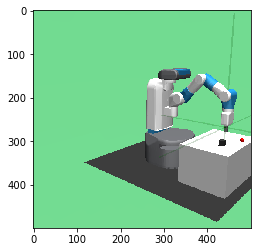

In [12]:
#actor_model.load_weights("chet_actor140v5.h5")
#critic_model.load_weights("chet_critic140v5.h5")

#target_actor.load_weights("chet_target_actor140v5.h5")
#target_critic.load_weights("chet_target_critic140v5.h5")


img = plt.imshow(env.render(mode='rgb_array')) # only call this once
success=0
for j in range(10):
    env.reset()
    for j in range(50):
        
        
        img.set_data(env.render(mode='rgb_array')) # just update the data
        display.display(plt.gcf())
        display.clear_output(wait=True)
        
        
        #env.render()
        action = env.action_space.sample()
    #env.step(action)  #investigate 
        state, reward, done, info = env.step(action)
        if reward==0:
            print("reached target at timestep",i)
            success+=1
            break
print("sucesses=",success)


In [ ]:

"""
actor_model.load_weights("chet_actor200v7.h5")
critic_model.load_weights("chet_critic200v7.h5")

target_actor.load_weights("chet_target_actor200v87.h5")
target_critic.load_weights("chet_target_critic200v7.h5")

with open('rewardlist200v8.txt', 'w') as filehandle:
    for listitem in ep_reward_list:
        filehandle.write('%s\n' % listitem)
"""      

In [177]:
import matplotlib.pyplot as plt
import gym
from IPython import display
%matplotlib inline

env = gym.make('CartPole-v0')
env.reset()




DependencyNotInstalled: Found neither the ffmpeg nor avconv executables. On OS X, you can install ffmpeg via `brew install ffmpeg`. On most Ubuntu variants, `sudo apt-get install ffmpeg` should do it. On Ubuntu 14.04, however, you'll need to install avconv with `sudo apt-get install libav-tools`.